# SEER Lung Short Dataset Exploration

Insights drawn from the (`SEER_Lung.csv`) focusing on feature patterns against the `Vital status recode` label.


In [1]:
# 데이터 분석 및 시각화에 필요한 라이브러리들을 가져옵니다.
# pathlib: 파일 경로를 쉽게 다루기 위한 라이브러리
from pathlib import Path
# display: Jupyter Notebook에서 데이터프레임 등을 예쁘게 출력하기 위해 사용
from IPython.display import display
# matplotlib.pyplot: 데이터 시각화를 위한 기본 라이브러리
import matplotlib.pyplot as plt
# matplotlib.ticker: 그래프의 눈금(tick)을 설정하기 위해 사용
import matplotlib.ticker as mstick
# pandas: 데이터 조작 및 분석을 위한 핵심 라이브러리 (표 형태의 데이터를 다룸)
import pandas as pd
# seaborn: matplotlib을 기반으로 더 아름답고 통계적인 그래프를 그리기 위한 라이브러리
import seaborn as sns

# seaborn의 기본 테마를 설정합니다. 'whitegrid' 스타일과 'crest' 색상 팔레트를 사용합니다.
sns.set_theme(style="whitegrid", palette="crest")


In [2]:
# 시각화에서 한글이 깨지지 않도록 나눔고딕 폰트를 설정합니다.
# 시스템에 폰트가 설치되어 있지 않으면 오류가 발생할 수 있어 try-except 구문으로 감쌌습니다.
try:
    plt.rc('font', family='NanumGothic')
except Exception:
    pass
# 마이너스 부호가 깨지는 것을 방지하는 설정입니다.
plt.rc('axes', unicode_minus=False)


## Load dataset


In [3]:
# 데이터 파일의 경로를 지정합니다.
DATA_PATH = Path('../data/SEER_Lung.csv')
SURGERY_CROSSWALK_PATH = Path('../data/encode/Lung-Surgery-Code-Crosswalk__2003-2022_to_2023.csv')

# 수술 코드 값을 정규화하는 함수를 정의합니다. (예: '20.0' -> '20')
def normalize_surgery_code(value):
    if pd.isna(value):
        return pd.NA
    value_str = str(value).strip()
    if value_str.endswith('.0'):
        value_str = value_str[:-2] or '0'
    return value_str

# CSV 파일을 pandas 데이터프레임으로 읽어옵니다.
df = pd.read_csv(DATA_PATH)
# 불필요한 'Unnamed: 0' 컬럼이 있다면 삭제합니다.
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
# 컬럼 이름을 더 간결하게 변경합니다.
df = df.rename(columns={'Vital status recode (study cutoff used)': 'Vital status recode'})
# 'Survival months' 컬럼을 숫자형으로 변환합니다. 변환할 수 없는 값은 결측치(NaN)로 처리합니다.
df['Survival months'] = pd.to_numeric(df['Survival months'], errors='coerce')
# 'Primary Site - labeled' 컬럼의 데이터 타입을 문자열로 바꾸고, 양쪽 공백을 제거합니다.
if 'Primary Site - labeled' in df.columns:
    df['Primary Site - labeled'] = df['Primary Site - labeled'].astype('string').str.strip()

# 수술 코드와 설명을 매핑하기 위한 crosswalk 파일을 읽어옵니다.
surgery_crosswalk = (
    pd.read_csv(SURGERY_CROSSWALK_PATH)
      .rename(columns={'From Definition ': 'From Definition'})
      [['From Code', 'From Definition']]
      .dropna(subset=['From Code'])
)
# crosswalk 데이터의 수술 코드를 정규화하고, 설명의 공백을 제거합니다.
surgery_crosswalk['From Code'] = surgery_crosswalk['From Code'].map(normalize_surgery_code)
surgery_crosswalk['From Definition'] = surgery_crosswalk['From Definition'].str.strip()
surgery_crosswalk = surgery_crosswalk.dropna(subset=['From Code']).drop_duplicates('From Code', keep='first')
# 수술 코드를 키(key)로, 설명을 값(value)으로 하는 딕셔너리를 만듭니다.
surgery_code_map = dict(zip(surgery_crosswalk['From Code'], surgery_crosswalk['From Definition']))

# 원본 데이터프레임의 수술 코드를 위에서 만든 딕셔너리를 이용해 설명으로 바꿉니다.
# 이렇게 하면 '20' 같은 코드 대신 'Lobectomy' 같은 사람이 읽기 쉬운 텍스트로 시각화할 수 있습니다.
surgery_codes = df['RX Summ--Surg Prim Site (1998+)'].map(normalize_surgery_code)
df['RX Summ--Surg Prim Site (1998+)'] = surgery_codes.map(surgery_code_map).fillna(surgery_codes)

# 분석의 목표가 되는 컬럼(타겟 변수)을 지정합니다.
TARGET_COL = 'Vital status recode'
# 타겟 변수를 제외한 나머지 컬럼들을 특성(feature) 컬럼으로 정의합니다.
feature_cols = [col for col in df.columns if col != TARGET_COL]
# 데이터 처리 후 상위 5개 행을 출력하여 확인합니다.
df.head()


,Patient ID,Age recode with <1 year olds and 90+,Sex,Year of diagnosis,"Race recode (W, B, AI, API)","Origin recode NHIA (Hispanic, Non-Hisp)","Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",Sequence number,Marital status at diagnosis,Primary Site,Primary Site - labeled,Histologic Type ICD-O-3,Grade Recode (thru 2017),Laterality,RX Summ--Surg Prim Site (1998+),Radiation recode,"Chemotherapy recode (yes, no/unk)",Survival months,Vital status recode,COD to site recode
0,671,65-69 years,Male,2018,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,2nd of 2 or more primaries,Divorced,341,"C34.1-Upper lobe, lung",8140,Blank(s),Right - origin of primary,Lobectomy WITH mediastinal lymph node dissection,None/Unknown,Yes,59.0,Alive,Alive
1,894,65-69 years,Female,2016,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,2nd of 2 or more primaries,Single (never married),340,C34.0-Main bronchus,8140,Unknown,Left - origin of primary,None; no surgery of primary site; autopsy ONLY,Beam radiation,Yes,27.0,Dead,Lung and Bronchus
2,1258,80-84 years,Female,2015,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,2nd of 2 or more primaries,Widowed,341,"C34.1-Upper lobe, lung",8550,Poorly differentiated; Grade III,Left - origin of primary,Lobectomy WITH mediastinal lymph node dissection,None/Unknown,No/Unknown,52.0,Dead,Lung and Bronchus
3,1421,65-69 years,Female,2020,White,Non-Spanish-Hispanic-Latino,Non-Hispanic White,2nd of 2 or more primaries,Single (never married),341,"C34.1-Upper lobe, lung",8140,Blank(s),Right - origin of primary,None; no surgery of primary site; autopsy ONLY,None/Unknown,No/Unknown,12.0,Dead,Vulva
4,1484,85-89 years,Male,2018,Asian or Pacific Islander,Non-Spanish-Hispanic-Latino,Non-Hispanic Asian or Pacific Islander,2nd of 2 or more primaries,Married (including common law),343,"C34.3-Lower lobe, lung",8140,Blank(s),Left - origin of primary,Lobectomy WITH mediastinal lymph node dissection,None/Unknown,No/Unknown,59.0,Alive,Alive


## Data health checks


In [4]:
# 데이터프레임의 전체적인 정보를 출력합니다.
# 각 컬럼의 데이터 타입, null이 아닌 값의 개수 등을 확인할 수 있어 데이터 분석 전에 필수적입니다.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393999 entries, 0 to 393998
Data columns (total 20 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   Patient ID                                                  393999 non-null  int64  
 1   Age recode with <1 year olds and 90+                        393999 non-null  object 
 2   Sex                                                         393999 non-null  object 
 3   Year of diagnosis                                           393999 non-null  int64  
 4   Race recode (W, B, AI, API)                                 393999 non-null  object 
 5   Origin recode NHIA (Hispanic, Non-Hisp)                     393999 non-null  object 
 6   Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)  393999 non-null  object 
 7   Sequence number                                             393999 non-nul

In [5]:
# 각 컬럼별 결측치(missing values)의 개수를 확인합니다.
# 시각화나 모델링 전에 결측치를 어떻게 처리할지 결정해야 합니다.
df.isna().sum().to_frame(name='missing_values')


,missing_values
Patient ID,0
Age recode with <1 year olds and 90+,0
Sex,0
Year of diagnosis,0
"Race recode (W, B, AI, API)",0
"Origin recode NHIA (Hispanic, Non-Hisp)",0
"Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",0
Sequence number,0
Marital status at diagnosis,0
Primary Site,0


In [6]:
# 'Primary Site'와 'Primary Site - labeled' 컬럼에 어떤 고유한 값들이 있는지 확인합니다.
print(df['Primary Site'].unique())
print(df['Primary Site - labeled'].unique())

[341 340 343 349 342 348]
<StringArray>
[          'C34.1-Upper lobe, lung',              'C34.0-Main bronchus',
           'C34.3-Lower lobe, lung',                  'C34.9-Lung, NOS',
          'C34.2-Middle lobe, lung', 'C34.8-Overlapping lesion of lung']
Length: 6, dtype: string


## Label balance


In [7]:
# 타겟 변수인 'Vital status recode'의 값(Alive, Dead)별 개수와 비율을 계산합니다.
# 데이터가 불균형한지 확인하는 것은 모델 성능에 큰 영향을 미치므로 중요합니다.
label_counts = df[TARGET_COL].value_counts().rename('count')
label_share = (label_counts / len(df)).rename('proportion')
pd.concat([label_counts, label_share], axis=1)


,count,proportion
Vital status recode,,
Dead,260512,0.6612
Alive,133487,0.3388


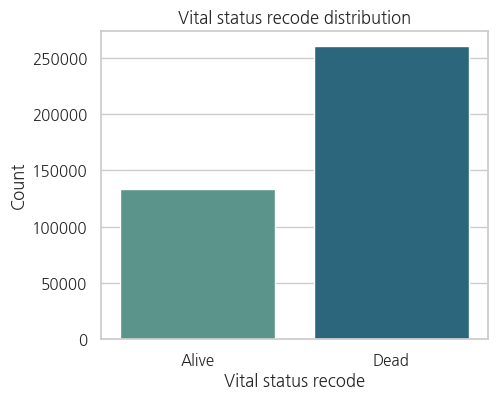

In [8]:
# 시각화를 위한 그림(figure)의 크기를 설정합니다. (가로 5인치, 세로 4인치)
plt.figure(figsize=(5, 4))
# seaborn의 countplot을 사용하여 타겟 변수의 분포를 막대 그래프로 그립니다.
sns.countplot(
    data=df, # 사용할 데이터프레임
    x=TARGET_COL, # x축에 표시할 컬럼
    palette='crest', # 사용할 색상 팔레트
    hue='Vital status recode' # 'Vital status recode' 값에 따라 다른 색으로 표시
)
# 그래프의 제목을 설정합니다.
plt.title('Vital status recode distribution')
# x축의 라벨을 설정합니다.
plt.xlabel('Vital status recode')
# y축의 라벨을 설정합니다.
plt.ylabel('Count')
# 그래프를 화면에 보여줍니다.
plt.show()


## Treatment and demographic signals
Key categorical drivers broken down by survival outcome.


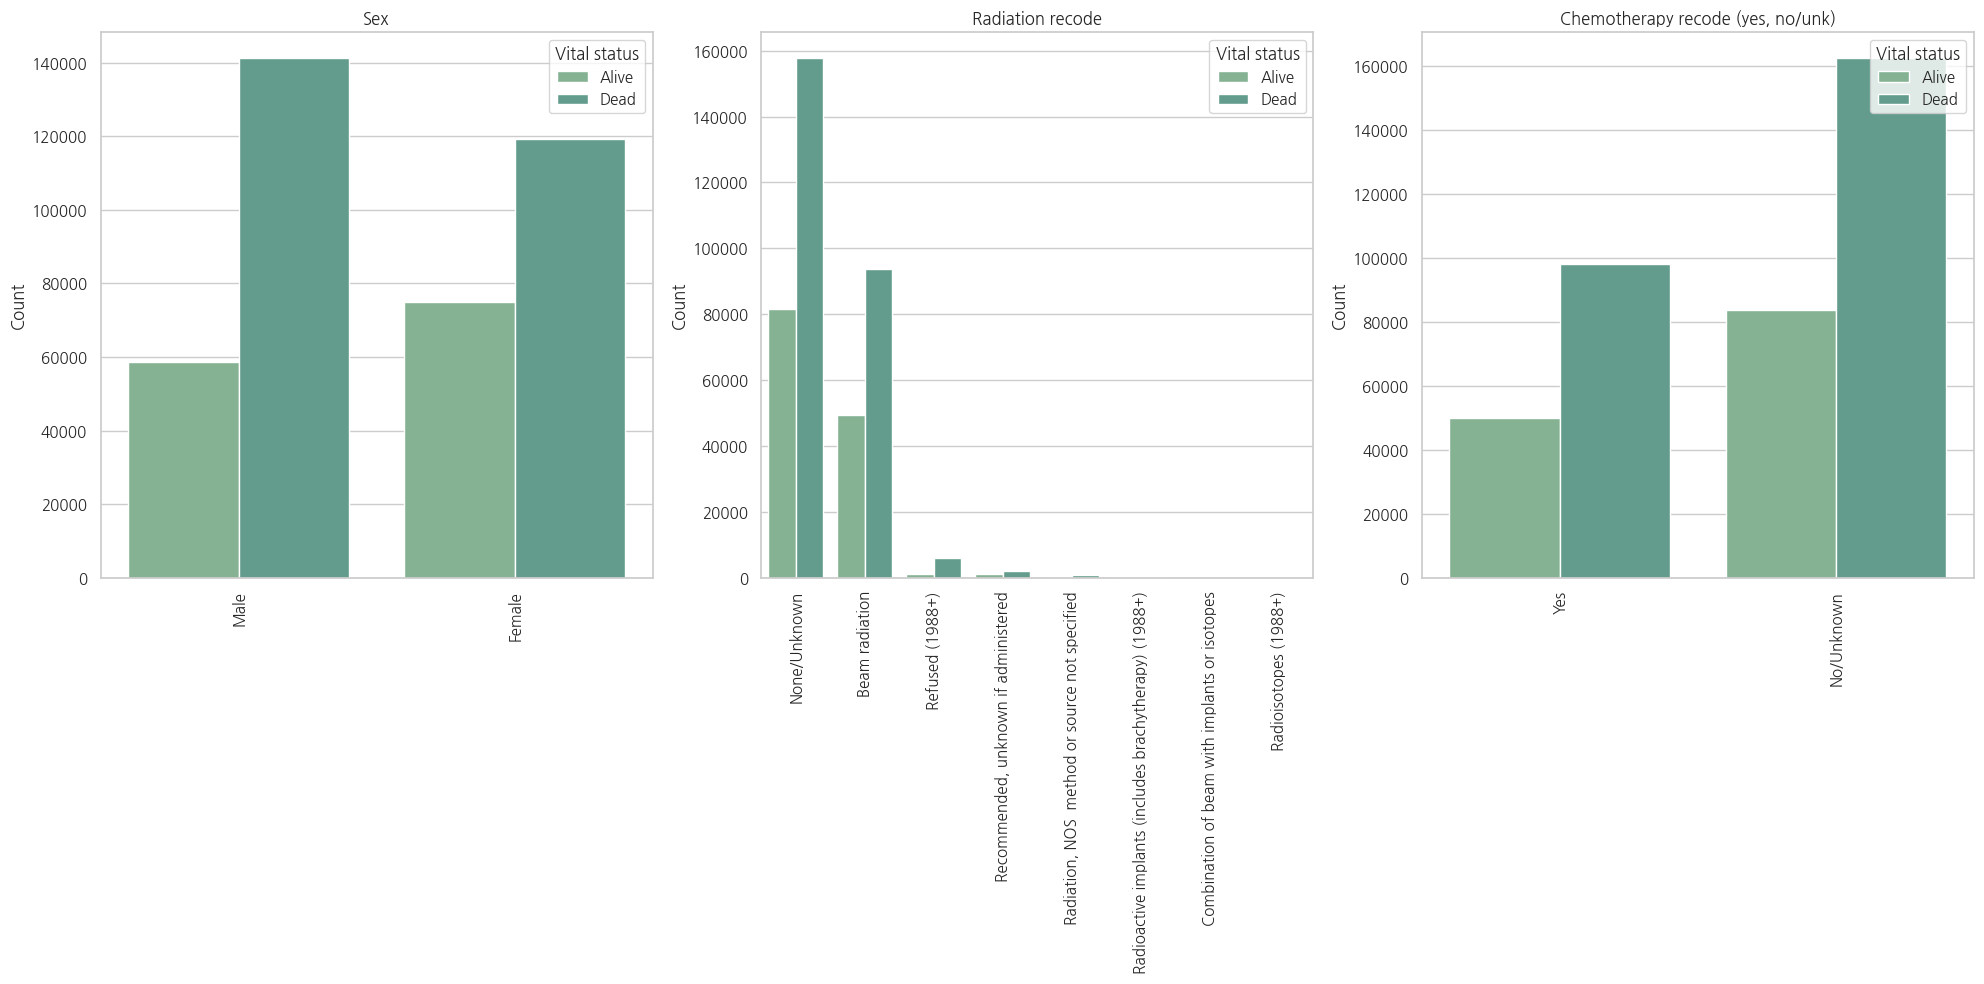

In [9]:
# 분석할 범주형 특성들의 리스트를 정의합니다.
categorical_features = [
    'Sex',
    'Radiation recode',
    'Chemotherapy recode (yes, no/unk)'
]

# 여러 개의 그래프를 한 번에 그리기 위해 subplots를 생성합니다. (1행 3열)
fig, axes = plt.subplots(1, len(categorical_features), figsize=(20, 10))
# for 루프를 사용하여 각 특성에 대한 countplot을 그립니다.
for ax, feature in zip(axes, categorical_features):
    # 각 subplot(ax)에 countplot을 그립니다.
    sns.countplot(data=df, x=feature, hue=TARGET_COL, ax=ax)
    ax.set_title(feature) # subplot의 제목 설정
    ax.set_xlabel('') # x축 라벨은 비워둠
    ax.set_ylabel('Count') # y축 라벨 설정
    ax.tick_params(axis='x', rotation=90) # x축 눈금 라벨을 90도 회전하여 겹치지 않게 함
    ax.legend(title='Vital status', loc='upper right') # 범례 설정

# 그래프들이 겹치지 않도록 레이아웃을 자동으로 조정합니다.
plt.tight_layout()
# 최종 그래프를 보여줍니다.
plt.show()


In [10]:
# 특성(feature)별로 생존/사망 비율을 계산하는 함수를 정의합니다.
def crosstab_percent(feature):
    # pd.crosstab으로 교차표를 생성하고, normalize='index'로 각 행의 합이 1이 되도록 정규화(비율 계산)합니다.
    table = pd.crosstab(df[feature], df[TARGET_COL], normalize='index')
    # 백분율로 변환하고 소수점 첫째 자리까지 반올림합니다.
    return (table * 100).round(1).add_suffix(' (%)')

# 위에서 정의한 범주형 특성들에 대해 각각 교차표를 만들어 출력합니다.
# 이를 통해 막대 그래프로 본 내용을 정확한 수치로 확인할 수 있습니다.
for feature in categorical_features:
    display(crosstab_percent(feature))


Vital status recode,Alive (%),Dead (%)
Sex,,
Female,38.6,61.4
Male,29.3,70.7


Vital status recode,Alive (%),Dead (%)
Radiation recode,,
Beam radiation,34.5,65.5
Combination of beam with implants or isotopes,25.5,74.5
None/Unknown,34.1,65.9
"Radiation, NOS method or source not specified",26.8,73.2
Radioactive implants (includes brachytherapy) (1988+),39.2,60.8
Radioisotopes (1988+),29.3,70.7
"Recommended, unknown if administered",32.6,67.4
Refused (1988+),16.5,83.5


Vital status recode,Alive (%),Dead (%)
"Chemotherapy recode (yes, no/unk)",,
No/Unknown,34.0,66.0
Yes,33.7,66.3


### Feature correlation
Heatmap of numeric features after excluding `Patient ID` and encoding `Vital status recode` to inspect its relationship with other predictors.


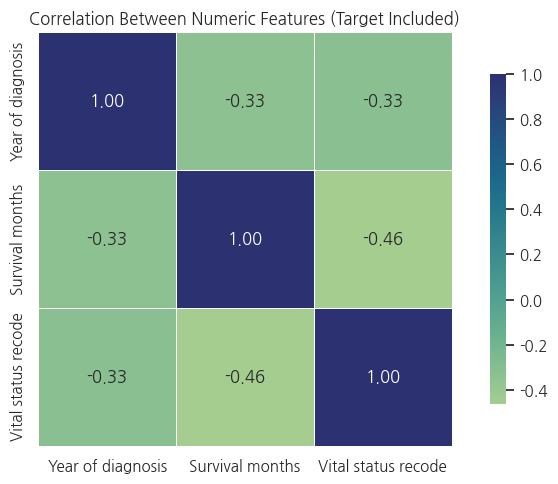

,Year of diagnosis,Survival months,Vital status recode
Year of diagnosis,1.000000,-0.334010,-0.325969
Survival months,-0.334010,1.000000,-0.464306
Vital status recode,-0.325969,-0.464306,1.000000


In [11]:
# 상관관계 분석을 위해 불필요한 ID 컬럼 등을 제외하고 데이터프레임을 복사합니다.
corr_df = df.drop(columns=['Patient ID', 'Primary Site', 'Histologic Type ICD-O-3'], errors='ignore').copy()
# 상관관계 계산을 위해 타겟 변수를 숫자(Alive: 0, Dead: 1)로 변환합니다.
corr_df['Vital status recode'] = corr_df['Vital status recode'].map({'Alive': 0, 'Dead': 1})
# 숫자형 데이터만 선택하고, 모든 값이 결측치인 컬럼은 제외합니다.
numeric_corr = corr_df.select_dtypes(include='number').dropna(axis=1, how='all')
# 피어슨 상관계수 행렬을 계산합니다.
corr_matrix = numeric_corr.corr()

# 히트맵을 그리기 위한 figure 크기를 설정합니다.
plt.figure(figsize=(8, 5))
# seaborn의 heatmap을 사용하여 상관계수 행렬을 시각화합니다.
sns.heatmap(
    corr_matrix, # 시각화할 데이터 (상관계수 행렬)
    annot=True, # 각 셀에 숫자 값을 표시
    fmt='.2f', # 숫자를 소수점 둘째 자리까지 표시
    cmap='crest', # 색상 맵 지정
    linewidths=0.5, # 셀 사이의 선 두께
    square=True, # 셀을 정사각형으로 만듦
    cbar_kws={'shrink': 0.8} # 컬러바 크기 조정
)
plt.title('Correlation Between Numeric Features (Target Included)') # 그래프 제목 설정
plt.tight_layout() # 레이아웃 조정
plt.show() # 그래프 표시

# 계산된 상관계수 행렬을 출력하여 수치를 확인합니다.
corr_matrix


In [12]:
import numpy as np
from pandas.api.types import (
    is_categorical_dtype,
    is_object_dtype,
    is_string_dtype,
)

# 두 범주형 변수 사이의 연관성을 측정하는 크래머 V(Cramér's V) 계수를 계산하는 함수입니다.
# 피어슨 상관계수가 숫자형 변수 간의 선형 관계를 측정하는 것과 달리, 크래머 V는 범주형 변수 간의 연관 강도를 측정합니다.
def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    if contingency.empty:
        return np.nan
    observed = contingency.values.astype(float)
    n = observed.sum()
    if n == 0:
        return np.nan
    row_sum = observed.sum(axis=1, keepdims=True)
    col_sum = observed.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2 = np.nansum((observed - expected) ** 2 / expected)
    phi2 = chi2 / n
    r, k = observed.shape
    phi2corr = max(0, phi2 - (k - 1) * (r - 1) / max(n - 1, 1))
    rcorr = r - (r - 1) ** 2 / max(n - 1, 1)
    kcorr = k - (k - 1) ** 2 / max(n - 1, 1)
    denom = max(min(rcorr - 1, kcorr - 1), 1e-12)
    return np.sqrt(phi2corr / denom)

# 데이터프레임에서 범주형으로 볼 수 있는 컬럼들을 선택합니다.
categorical_cols = [
    col for col in df.columns
    if col not in {'Vital status recode', 'COD to site recode'}
    and (
        is_object_dtype(df[col])
        or is_string_dtype(df[col])
        or is_categorical_dtype(df[col])
    )
]

target = df['Vital status recode']
# 각 범주형 특성과 타겟 변수 간의 크래머 V 점수를 계산합니다.
cramers_scores = {col: cramers_v(df[col], target) for col in categorical_cols}
# 점수를 내림차순으로 정렬하여 어떤 특성이 타겟과 가장 강한 연관성을 갖는지 확인합니다.
assoc_df = (pd.Series(cramers_scores, name='cramers_v')
             .sort_values(ascending=False))
assoc_df.to_frame().T if assoc_df.empty else assoc_df.to_frame()


/tmp/ipykernel_19840/3920476079.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  or is_categorical_dtype(df[col])


,cramers_v
RX Summ--Surg Prim Site (1998+),0.432159
Grade Recode (thru 2017),0.293570
Primary Site - labeled,0.192349
Age recode with <1 year olds and 90+,0.162672
Laterality,0.149068
Sequence number,0.107190
Sex,0.097455
Marital status at diagnosis,0.087978
"Race recode (W, B, AI, API)",0.061503
"Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",0.060397


## Survival months by outcome


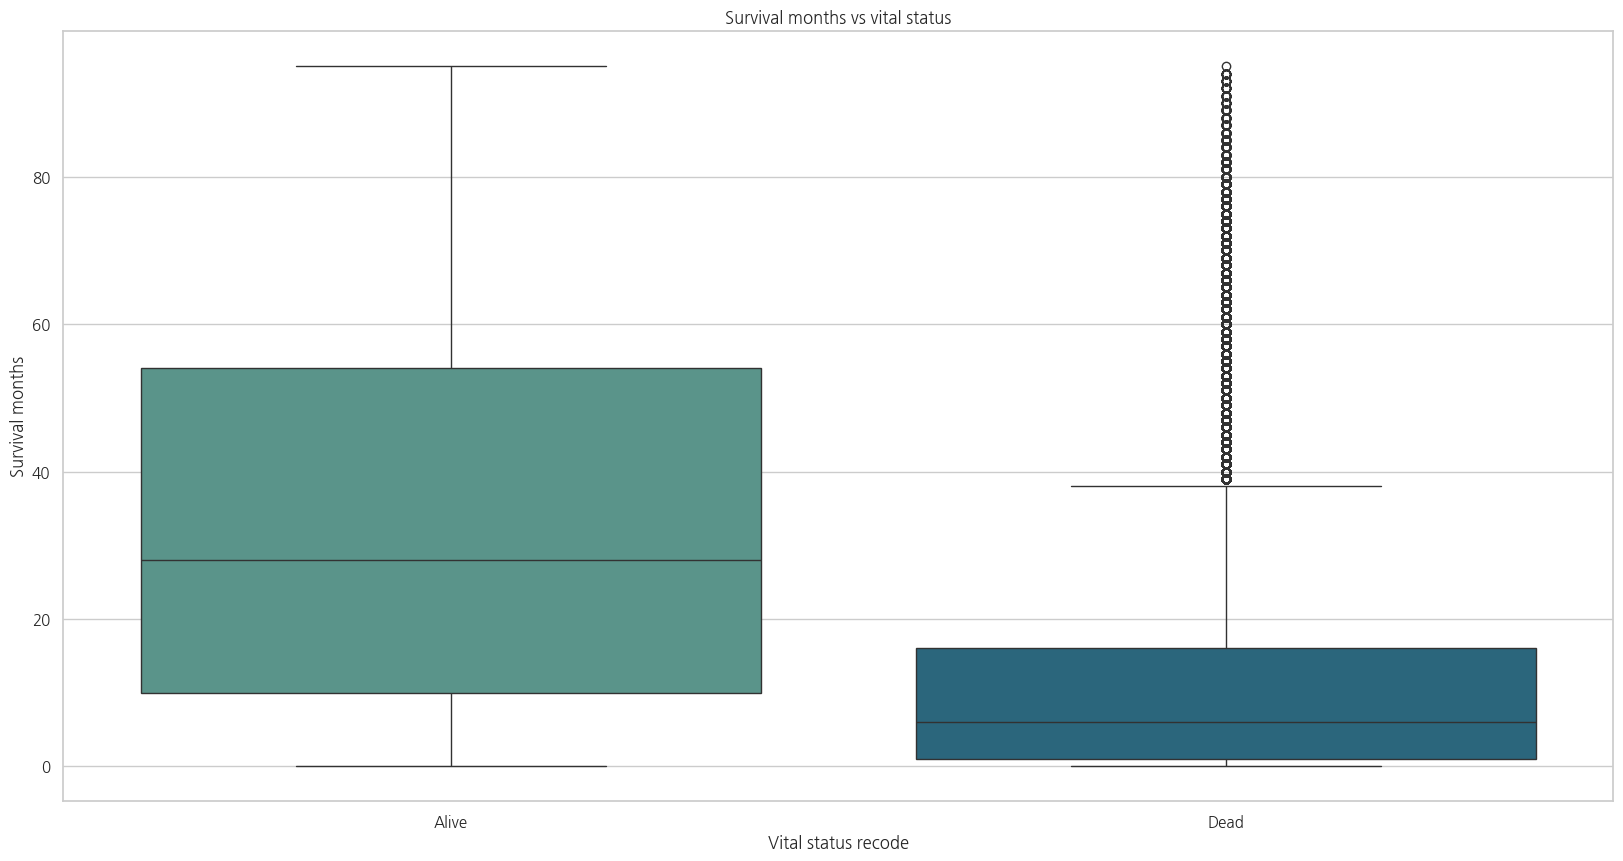

In [13]:
# 박스플롯(boxplot)을 그리기 위한 figure 크기를 설정합니다.
plt.figure(figsize=(20, 10))
# seaborn의 boxplot을 사용하여 생존/사망 그룹별 생존 기간의 분포를 시각화합니다.
# 박스플롯은 데이터의 중앙값, 사분위수, 이상치 등을 한눈에 보여줍니다.
sns.boxplot(data=df, x=TARGET_COL, y='Survival months', palette='crest', hue='Vital status recode')
plt.title('Survival months vs vital status') # 제목 설정
plt.xlabel('Vital status recode') # x축 라벨 설정
plt.ylabel('Survival months') # y축 라벨 설정
plt.show() # 그래프 표시


In [14]:
# 위 박스플롯의 내용을 수치로 확인하기 위해 그룹별 통계량을 계산합니다.
agg_stats = (
    df.groupby(TARGET_COL)['Survival months']
      .agg(count='count', mean='mean', median='median', min='min', max='max')
      .round(1)
)
agg_stats


,count,mean,median,min,max
Vital status recode,,,,,
Alive,133487,33.8,28.0,0.0,95.0
Dead,250702,11.8,6.0,0.0,95.0


In [15]:
# 진단 연도를 기준으로 시대를 구분하기 위한 구간과 라벨을 정의합니다.
era_bins = [2014, 2016, 2018, 2020, 2022]
era_labels = ['2015-2016', '2017-2018', '2019-2020', '2021-2022']

# 시대별 생존 분석을 위한 데이터를 준비합니다.
survival_by_era = (
    df[['Year of diagnosis', 'Survival months', 'Vital status recode']]
      .dropna(subset=['Year of diagnosis', 'Survival months', 'Vital status recode'])
      .assign(
          **{
              'Year of diagnosis': lambda d: pd.to_numeric(d['Year of diagnosis'], errors='coerce'),
              'Survival months': lambda d: pd.to_numeric(d['Survival months'], errors='coerce'),
          }
      )
      .dropna(subset=['Year of diagnosis', 'Survival months'])
      .assign(
          **{
              # pd.cut을 사용하여 'Year of diagnosis'를 'Diagnosis era'로 변환합니다.
              'Diagnosis era': lambda d: pd.cut(
                  d['Year of diagnosis'],
                  bins=era_bins,
                  labels=era_labels,
                  include_lowest=True,
                  right=True
              )
          }
      )
      .dropna(subset=['Diagnosis era'])
      .copy()
)

survival_by_era.head()


,Year of diagnosis,Survival months,Vital status recode,Diagnosis era
0,2018,59.0,Alive,2017-2018
1,2016,27.0,Dead,2015-2016
2,2015,52.0,Dead,2015-2016
3,2020,12.0,Dead,2019-2020
4,2018,59.0,Alive,2017-2018


In [ ]:
# 사망한 환자들의 생존 기간(mont)에 대한 기술 통계량을 계산합니다.
death_timing = (
    df[['Survival months', 'Vital status recode']]
      .dropna(subset=['Survival months', 'Vital status recode'])
      .assign(
          **{
              'Survival months': lambda d: pd.to_numeric(d['Survival months'], errors='coerce'),
          }
      )
      .dropna(subset=['Survival months'])
      .loc[lambda d: d['Vital status recode'] == 'Dead']
      .assign(**{'Survival months': lambda d: d['Survival months'].clip(lower=0)})
      .copy()
)

death_timing['Survival months'].describe()


count    250702.000000
mean         11.761897
std          15.371750
min           0.000000
25%           1.000000
50%           6.000000
75%          16.000000
max          95.000000
Name: Survival months, dtype: float64

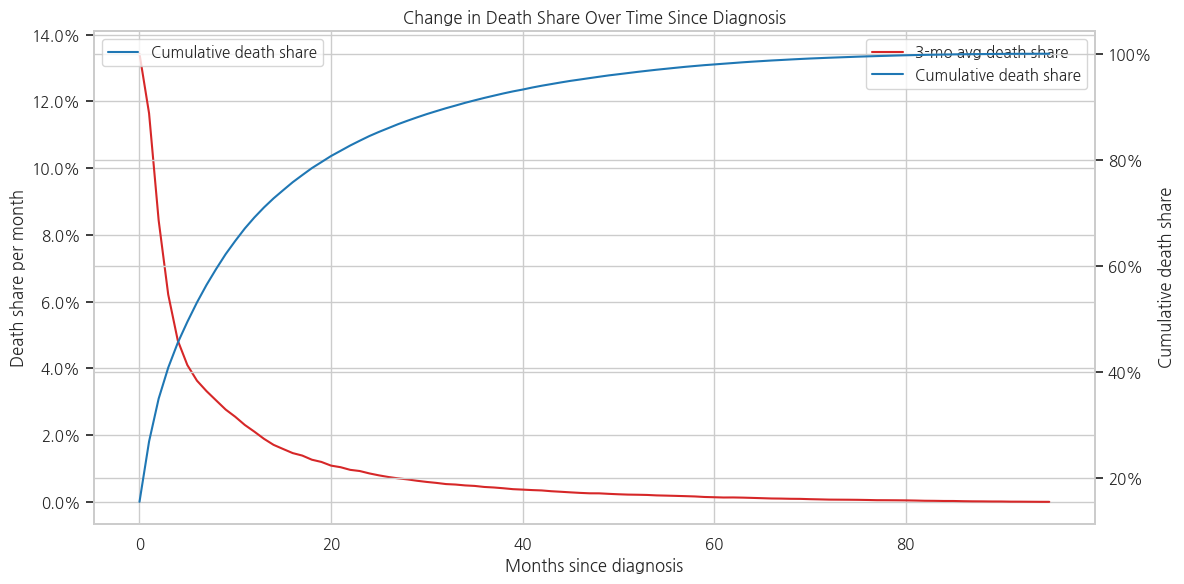

,Month since diagnosis,Deaths,Death share,Death share (3-mo avg),Cumulative death share
0,0,38768,0.154638,0.134243,0.154638
1,1,28542,0.113848,0.116405,0.268486
2,2,20239,0.080729,0.084378,0.349215
3,3,14680,0.058556,0.062127,0.407771
4,4,11807,0.047096,0.048352,0.454867


In [ ]:
# 진단 후 경과 월에 따른 월별 및 누적 사망 비중 변화를 시각화합니다.
monthly_death = (
    death_timing
      .assign(**{'Month since diagnosis': lambda d: d['Survival months'].round().astype(int)})
      .groupby('Month since diagnosis')
      .size()
      .reindex(range(0, int(death_timing['Survival months'].max()) + 1), fill_value=0)
      .rename('Deaths')
      .reset_index()
)

monthly_death['Death share'] = monthly_death['Deaths'] / monthly_death['Deaths'].sum()
monthly_death['Death share (3-mo avg)'] = (
    monthly_death['Death share']
      .rolling(window=3, center=True, min_periods=1)
      .mean()
)
monthly_death['Cumulative death share'] = monthly_death['Death share'].cumsum()

fig, ax1 = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=monthly_death,
    x='Month since diagnosis',
    y='Death share (3-mo avg)',
    ax=ax1,
    label='3-mo avg death share',
    color='#d62728'
)
ax1.set_ylabel('Death share per month')
ax1.yaxis.set_major_formatter(mstick.PercentFormatter(1.0))
ax1.set_xlabel('Months since diagnosis')

ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_death,
    x='Month since diagnosis',
    y='Cumulative death share',
    ax=ax2,
    label='Cumulative death share',
    color='#1f77b4'
)
ax2.set_ylabel('Cumulative death share')
ax2.yaxis.set_major_formatter(mstick.PercentFormatter(1.0))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Change in Death Share Over Time Since Diagnosis')
plt.tight_layout()
plt.show()

monthly_death.head()